# Training T5 - Prefix+Idiom



#0. Installs, Imports, Setup


##0.1 Import Libraries & Packages

In [ ]:
!pip install sentencepiece -q
!pip install transformers -q
!pip install torch -q
!pip install rich[jupyter] -q

     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 4.2 MB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 36.1 MB/s 
     |████████████████████████████████| 596 kB 34.6 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 231 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 


In [ ]:
# Drive
from google.colab import drive

# Plots
import IPython
import IPython.display
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Util
import os
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_rows', None)

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# rich: for a better display on terminal
from rich.table import Column, Table
from rich.text import Text
from rich import box
from rich.console import Console

# define a rich console logger
console = Console(record=True)

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

<Figure size 864x432 with 0 Axes>

##0.2. Import Data

Either upload the data to the shared Google Drive and use this to download, or upload it directly yourself (whatever is easier)

In [ ]:
!git clone https://github.com/marziehf/IdiomTranslationDS data

Cloning into 'data'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


##0.3 Setup functions & classes

###0.3.1 FUNC: display_df

In [ ]:
# to display dataframe in ASCII format
def display_df(df):
    """display dataframe in ASCII format"""

    console = Console()
    table = Table(
        Column("source_text", justify="center"),
        Column("target_text", justify="center"),
        title="Sample Data",
        pad_edge=False,
        box=box.ASCII,
    )

    for i, row in enumerate(df.values.tolist()):
        table.add_row(row[0], row[1])

    console.print(table)

###0.3.2 CLASS: DataSet

A Dataset class for reading and loading the dataset into the dataloader, and then feed it into the neural network for fine-tuning the model.

In [ ]:
class DataSet(Dataset):
    """
    Creating a dataset class for reading the dataset and
    loading it into the dataloader, to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, dataframe, tokenizer, source_len, target_len, source_text, target_text
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

###0.3.3 FUNC: train

Train function, which will the put model on training mode, generate outputs and calculate loss

In [ ]:
def train(epoch, tokenizer, model, device, loader, optimizer, train_batch_size):

    """
    Function to be called for training with the parameters passed from main function

    Takes 6 arguments as input:
    
        epoch: epoch
        tokenizer: T5 tokenizer
        model: T5 model
        loader: Train Dataloader
        optimizer: Optimizer
        train_batch_size: batch size for the training data


    """

    model.train()
    train_loss = 0
    train_batches = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        train_loss += loss.item()
        train_batches += 1

        # Print training loss every 100 batches
        if _ % 100 == 0:
            #training_logger.add_row(str(epoch), str(_), str(loss.item()))
            console.print("Epoch: ", str(epoch), "Batch: ", str(_), "Loss: ", str(loss.item()))

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

    # Print average training loss over the epoch
    train_loss = train_loss/train_batches
    training_logger.add_row(str(epoch), str(train_loss))


###0.3.4 FUNC: validate

Validate function is same as the Train function, but for the validation data



In [ ]:
def validate(epoch, tokenizer, model, device, loader, generate_outputs=True):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  val_loss = 0
  batches = 0
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          # Find validation loss
          y_ids = y[:, :-1].contiguous()
          lm_labels = y[:, 1:].clone().detach()
          lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

          outputs = model(
              input_ids=ids,
              attention_mask=mask,
              decoder_input_ids=y_ids,
              labels=lm_labels
              )
          loss = outputs[0]
          val_loss += loss.item()
          batches += 1

          # Generate outputs
          if generate_outputs:
            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

            predictions.extend(preds)
            actuals.extend(target)

  # Save average loss over epoch
  val_loss = val_loss/batches
  if not generate_outputs:
    validation_logger.add_row(str(epoch), str(val_loss))

  return predictions, actuals

###0.3.5 FUNC: T5Trainer

T5Trainer is our main function. It accepts input data, model type, model paramters to fine-tune the model. Under the hood, it utilizes, our Dataset class for data handling, train function to fine tune the model, validate to evaluate the model.

In [ ]:
def T5Trainer(
    train_data, val_data, source_text, target_text, model_params, output_dir="./outputs/"
):

    """
    T5 trainer has 6 arguments:

      train_data: Input dataframe of training data
      val_data: Input dataframe of validation data
      source_text: Column name of the input text i.e. idiomatic sentence
      target_text: Column name of the target text i.e. literal sentence
      model_params: T5 model parameters
      output_dir: Output directory to save fine tuned T5 model.

    """

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # tokenizer for encoding the text
    tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

    # Defining the model. The model is then sent to device (GPU/TPU)
    model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Importing the raw dataset
    train_data = train_data[[source_text, target_text]]
    train_data = train_data.reset_index(drop=True)
    val_data = val_data[[source_text, target_text]]
    val_data = val_data.reset_index(drop=True)

    display_df(train_data.head(2))

    # Creation of Dataset and Dataloader
    console.print(f"TRAIN Dataset: {train_data.shape}")
    console.print(f"VALIDATION Dataset: {val_data.shape}\n")

    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = DataSet(
        train_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )
    val_set = DataSet(
        val_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )

    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for training and validation.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )

    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    train_batch_size = model_params["TRAIN_BATCH_SIZE"]
    for epoch in range(model_params["TRAIN_EPOCHS"]):
        train(epoch, tokenizer, model, device, training_loader, optimizer, train_batch_size)
        validate(epoch, tokenizer, model, device, val_loader, generate_outputs=False)

    console.print("\n")
    console.print(training_logger)
    console.print("\n")
    console.print(validation_logger)

    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

    # generating output for validation dataset
    console.log(f"[Generating Validation Outputs]...\n")
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({"Input": val_data[source_text], "Generated Text": predictions, "Actual Text": actuals})
    final_df.to_csv(os.path.join(output_dir, "predictions.csv"))

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Outputs Generated.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

# 1. Processing Data

In [ ]:
def clean_dataset(data):
  data_clean = data.copy(deep=True)
  for i in range(len(data_clean.columns)):
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&apos;', '\'', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&quot;', '\"', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#124;', '|', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#93;', ']', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#91;', '[', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&gt;', '>', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&lt;', '<', x))

  return data_clean

In [ ]:
base_path="data/en-de/"
en = pd.read_csv(base_path+'idiom_trainplus.en',sep='\n', header=None,names=['en'])
de = pd.read_csv(base_path+'idiom_trainplus.de',sep='\n', header=None,names=['de'])
info = pd.read_csv(base_path+'idiom_trainplus.info',sep='\t',header=None,names=["spread", "en_idiom", "de_idiom",'frequency'])
train_data = pd.concat([en,de,info],axis=1)
train_data.columns = ['input','target',"spread", "en_idiom", "de_idiom",'frequency']
train_data = train_data.drop(['spread','frequency',"en_idiom", "de_idiom"],axis=1)

en = pd.read_csv(base_path+'idiom_test.en',sep='\n', header=None,names=['en'])
de = pd.read_csv(base_path+'idiom_test.de',sep='\n', header=None,names=['de'])
test_data = pd.concat([en,de],axis=1)
test_data.columns = ['input','target']

train_info = pd.read_csv(base_path+'idiom_trainplus.info',sep='\t',header=None,names=["spread", "en_idiom", "de_idiom",'frequency'])
test_info = pd.read_csv(base_path+'idiom_test.info',sep='\t',header=None,names=["spread", "en_idiom", "de_idiom",'frequency'])

train_data = clean_dataset(train_data)
test_data = clean_dataset(test_data)

train_data['input'] = 'translate to german: '+ train_data['input'] + ' idiom: ' + train_info['en_idiom']
test_data['input'] = 'translate to german: '+ test_data['input'] + ' idiom: ' + test_info['en_idiom']

# train_data['input'] = 'translate to german: '+ train_data['input']
# test_data['input'] = 'translate to german: '+ test_data['input']

from sklearn.model_selection import train_test_split

train_data,val_data=train_test_split(train_data, test_size=0.15, random_state=42)

In [ ]:
train_data.head()

,input,target
1080,translate to german: EU integration is like a ...,Die Integration in die EU ist wie Tangotanzen ...
203,translate to german: Whenever we go to a West ...,"Jedes Mal , wenn wir in westafrikanische Lände..."
174,translate to german: I hope that the Irish pre...,"Ich möchte , daß die irische Präsidentschaft i..."
772,translate to german: In a nutshell it would in...,Kurz gesagt würde es die Belastung für den bri...
120,"translate to german: Very well located , easy ...",Die Mitarbeiter waren freundlich und das Hotel...


In [ ]:
test_data.head()

,input,target
0,"translate to german: In this day and age , whe...","In einer Zeit wie dieser , in der viele offens..."
1,"translate to german: In Romania , the election...",In Rumänien wird der Wahlkampf die Chance biet...
2,translate to german: Let us work to close the ...,Gemeinsam sollten wir wirksam die Schlupflöche...
3,translate to german: The region is easily reac...,"Das Gebiet ist mit der Eisenbahn erreichbar , ..."
4,translate to german: I cannot enter into debat...,"Ich kann mich auf keine Diskussion einlassen ,..."


In [ ]:
# Check max length
lengths_train_in = train_data["input"].str.split(" ")
lengths_test_in = test_data["input"].str.split(" ")
lengths_val_in = val_data["input"].str.split(" ")

print("Max number of tokens input = ", max(lengths_train_in.str.len().max(),lengths_test_in.str.len().max()))

lengths_train_tar = train_data["target"].str.split(" ")
lengths_test_tar = test_data["target"].str.split(" ")
lengths_val_tar = val_data["target"].str.split(" ")

print("Max number of tokens target = ", max(lengths_train_tar.str.len().max(),lengths_test_tar.str.len().max()))

Max number of tokens input =  173
Max number of tokens target =  144


#2. Training Model

In [ ]:
# let's define model parameters specific to T5
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-small/t5-large
    "TRAIN_BATCH_SIZE": 4,  # training batch size
    "VALID_BATCH_SIZE": 4,  # validation batch size
    "TRAIN_EPOCHS": 4,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 1e-4,  # learning rate
    "MAX_SOURCE_TEXT_LENGTH": 180,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 150,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}


In [ ]:
# Initialize training and validation loggers to keep track of model loss

# training logger to log training loss over the epochs and batches
training_logger = Table(
    Column("Epoch", justify="center"),
    # Column("Batch", justify="center"),
    Column("Loss", justify="center"),
    title="Training Loss",
    pad_edge=False,
    box=box.ASCII,
)

# validation logger to log validation loss over the epochs
validation_logger = Table(
    Column("Epoch", justify="center"),
    Column("Loss", justify="center"),
    title="Validation Loss",
    pad_edge=False,
    box=box.ASCII,
)


In [ ]:
%mkdir outputs

In [ ]:
# Train model
T5Trainer(train_data=train_data, val_data= val_data, source_text="input", target_text="target", model_params=model_params, output_dir="outputs")

[08:22:00] [Model]: Loading t5-small...                     <ipython-input-8-31ece74cb2e6>:23
                                                                                             

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

[08:22:22] [Data]: Reading data...                          <ipython-input-8-31ece74cb2e6>:33
                                                                                             

                                         Sample Data                                         
+-------------------------------------------------------------------------------------------+
|                source_text                  |                 target_text                 |
|---------------------------------------------+---------------------------------------------|
|translate to german: EU integration is like  |      Die Integration in die EU ist wie      |
|  a tango . It takes two for it to work .    |  Tangotanzen : Man braucht dazu immer zwei  |
|       idiom: it takes two to tango .        |                  Partner .                  |
|  translate to german: Whenever we go to a   |   Jedes Mal , wenn wir in westafrikanische  |
|West African country , we can see the extent | Länder kommen , stellen wir fest , wie groß |
| to which French influence is still present  |  der französische Einfluss dort noch ist .  |
|         there . idiom: to go west           |                                             |
+-------------------------------------------------------------------------------------------+

TRAIN Dataset: (1956, 2)

VALIDATION Dataset: (346, 2)

           [Initiating Fine Tuning]...                      <ipython-input-8-31ece74cb2e6>:88
                                                                                             

Epoch:  0 Batch:  0 Loss:  4.233535289764404

Epoch:  0 Batch:  100 Loss:  2.484811782836914

Epoch:  0 Batch:  200 Loss:  2.117764949798584

Epoch:  0 Batch:  300 Loss:  2.4978296756744385

Epoch:  0 Batch:  400 Loss:  2.4054718017578125

Epoch:  1 Batch:  0 Loss:  1.982193946838379

Epoch:  1 Batch:  100 Loss:  0.9603795409202576

Epoch:  1 Batch:  200 Loss:  1.2623844146728516

Epoch:  1 Batch:  300 Loss:  1.404774785041809

Epoch:  1 Batch:  400 Loss:  1.4859590530395508

Epoch:  2 Batch:  0 Loss:  1.3248718976974487

Epoch:  2 Batch:  100 Loss:  2.1089465618133545

Epoch:  2 Batch:  200 Loss:  1.9903963804244995

Epoch:  2 Batch:  300 Loss:  3.269692897796631

Epoch:  2 Batch:  400 Loss:  2.2143819332122803

Epoch:  3 Batch:  0 Loss:  1.4226529598236084

Epoch:  3 Batch:  100 Loss:  1.0403497219085693

Epoch:  3 Batch:  200 Loss:  1.8244768381118774

Epoch:  3 Batch:  300 Loss:  1.3215018510818481

Epoch:  3 Batch:  400 Loss:  2.4086802005767822

       Training Loss        
+--------------------------+
|Epoch |        Loss       |
|------+-------------------|
|  0   | 2.0477694633792027|
|  1   | 1.7750585413174151|
|  2   | 1.6584913291814136|
|  3   | 1.5825322456886433|
+--------------------------+

      Validation Loss       
+--------------------------+
|Epoch |        Loss       |
|------+-------------------|
|  0   | 1.6828273863627994|
|  1   | 1.642734820472783 |
|  2   | 1.6459462156240967|
|  3   | 1.634426518418323 |
+--------------------------+

[08:33:25] [Saving Model]...                               <ipython-input-8-31ece74cb2e6>:100
                                                                                             

[08:33:26] [Generating Validation Outputs]...              <ipython-input-8-31ece74cb2e6>:107
                                                                                             

[08:35:57] [Validation Outputs Generated.]                 <ipython-input-8-31ece74cb2e6>:114
                                                                                             

[Model] Model saved @ outputs/model_files

[Validation] Generation on Validation data saved @ outputs/predictions.csv

[Logs] Logs saved @ outputs/logs.txt

In [ ]:
# Save the training loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in training_logger.columns}
training_logger_df = pd.DataFrame(table_data)
training_logger_df.to_csv("outputs/"+"train_loss.csv", sep="=")

# Save the validation loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in validation_logger.columns}
validation_logger_df = pd.DataFrame(table_data)
validation_logger_df.to_csv("outputs/"+"val_loss.csv", sep="=")

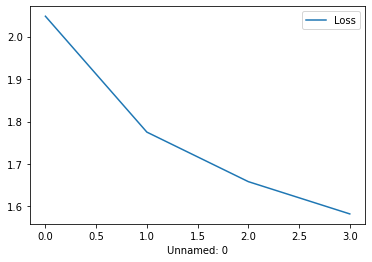

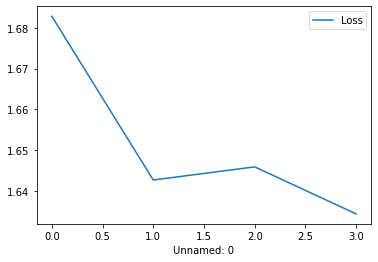

In [ ]:
# Plot the loss
train_loss = pd.read_csv("outputs/"+"train_loss.csv", sep="=")
train_loss.plot(0,2)
val_loss = pd.read_csv("outputs/"+"val_loss.csv", sep="=")
val_loss.plot(0,2)

In [ ]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/logs.txt (deflated 72%)
  adding: outputs/val_loss.csv (deflated 23%)
  adding: outputs/train_loss.csv (deflated 20%)
  adding: outputs/model_files/ (stored 0%)
  adding: outputs/model_files/config.json (deflated 63%)
  adding: outputs/model_files/spiece.model (deflated 48%)
  adding: outputs/model_files/tokenizer_config.json (deflated 80%)
  adding: outputs/model_files/pytorch_model.bin (deflated 8%)
  adding: outputs/model_files/special_tokens_map.json (deflated 83%)
  adding: outputs/predictions.csv (deflated 64%)
